# Resources 

* https://pypi.org/project/geocoder/1.8.0/
* batch geocoding : https://www.shanelynn.ie/batch-geocoding-in-python-with-google-geocoding-api/#script-code, https://developers.arcgis.com/documentation/mapping-apis-and-services/
* GHSL layer : https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2016_BUILT_LDSMT_GLOBE_V1?hl=en#bands
* Global Human modification : https://developers.google.com/earth-engine/datasets/catalog/CSP_HM_GlobalHumanModification#description
* Global Human Population layer : https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2016_POP_GPW_GLOBE_V1?hl=en#description
* Build up grid layer : https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2016_BUILT_LDSMT_GLOBE_V1?hl=en#bands
* world pop estimation layer : https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop_age_sex_cons_unadj?hl=en#bands

# Imports 

In [1]:
import pandas as pd 
import numpy as np 
import gc
import geopandas as gpd
import matplotlib.pyplot as plt

import folium
from folium.plugins import HeatMap
import geopy as gp
import ee
import ast




pd.set_option('display.max_rows',None)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
# ee.Authenticate()

In [4]:
ee.Initialize()

**Authenticating Arcgis API**

In [ ]:
# from arcgis.gis import GIS
# from arcgis.geoenrichment import *
# from arcgis.geoenrichment import Country, enrich,BufferStudyArea
# from arcgis.geometry import Point

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("ARCGIS_DEV_API")

# gis = GIS(api_key=secret_value_0)

# Loading individual csv files

In [5]:
path = '../input/housing-prices-in-metropolitan-areas-of-india'


df_banglore=pd.read_csv(path+'/Bangalore.csv')
df_chennai=pd.read_csv(path+'/Chennai.csv')
df_delhi=pd.read_csv(path+'/Delhi.csv')
df_hyderabad=pd.read_csv(path+'/Hyderabad.csv')
df_kolkata=pd.read_csv(path+'/Kolkata.csv')
df_mumbai=pd.read_csv(path+'/Mumbai.csv')

**merging into a single df**

In [6]:
df_banglore['City']='Bangalore, Karnataka'
df_chennai['City']='Chennai, Tamil Nadu'
df_delhi['City']='Delhi'
df_hyderabad['City']='Hyderabad,Telangana'
df_kolkata['City']='Kolkata, West Bengal'
df_mumbai['City']='Mumbai, Maharashtra'

df=pd.concat([df_banglore, df_chennai, df_delhi, df_hyderabad, df_kolkata, df_mumbai],axis=0,ignore_index=True)


del df_banglore,df_chennai,df_delhi,df_hyderabad,df_kolkata,df_mumbai ; gc.collect()
df.shape

(32963, 41)

In [7]:
#null values are repsresentated by 9. replacinng 9 by np.nan

df.replace(to_replace=9,value=np.nan,inplace=True)

df.isnull().sum()

Price                      0
Area                       0
Location                   0
No. of Bedrooms            1
Resale                     0
MaintenanceStaff       22870
Gymnasium              22870
SwimmingPool           22870
LandscapedGardens      22870
JoggingTrack           22870
RainWaterHarvesting    22870
IndoorGames            22870
ShoppingMall           22870
Intercom               22870
SportsFacility         22870
ATM                    22870
ClubHouse              22870
School                 22870
24X7Security           22870
PowerBackup            22870
CarParking             22870
StaffQuarter           22870
Cafeteria              22870
MultipurposeRoom       22870
Hospital               22870
WashingMachine         22870
Gasconnection          22870
AC                     22870
Wifi                   22870
Children'splayarea     22870
LiftAvailable          22870
BED                    22870
VaastuCompliant        22870
Microwave              22870
GolfCourse    

In [8]:
df['Address']= df.Location.str.lower().str.strip() + ', ' + df['City'].str.lower()

print('Number of unique locations %s'%df.Address.nunique())

Number of unique locations 1789


<AxesSubplot:title={'center':'Count by city'}>

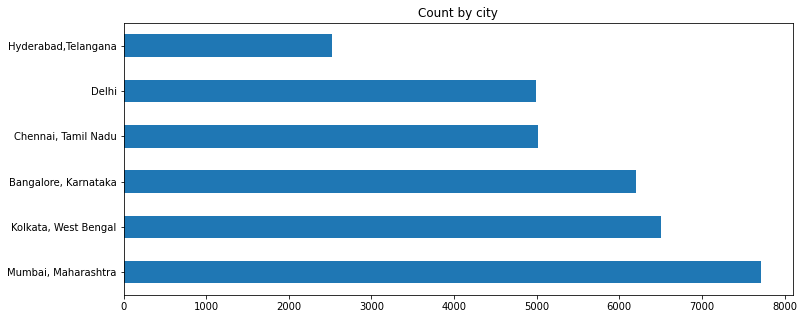

In [9]:
df.City.value_counts().plot.barh(figsize=(12,5),title='Count by city')

# Geocoding address

In [10]:
arcgis_geocoder = gp.geocoders.ArcGIS()

def geocode(address:list,
            geocoder=arcgis_geocoder):
    
    '''geocode a list a addresses, returning the address and lat/long'''
    
    lat,lon = [],[]
    
    for add in address:
        
        try :
            coded = geocoder.geocode(add)
            
            lat.append(coded.latitude)
            lon.append(coded.longitude)
            
        except Exception as e:
            print(e)
            
            lat.append(np.nan)
            lon.append(np.nan)
            
            
    return pd.DataFrame({'Address':address,
                         'latitude':lat,
                         'longitude':lon})
            

In [13]:
# %%time
# geocoded_loc = geocode(address= df.Address.unique())
geocoded_loc= pd.read_csv('../input/geocoding-and-feature-processing-housing-data/geocoded.csv')

#save location info
geocoded_loc.to_csv('geocoded.csv',index=False)

geocoded_loc.head()

,Address,latitude,longitude
0,"jp nagar phase 1, bangalore, karnataka",12.909960,77.585660
1,"dasarahalli on tumkur road, bangalore, karnataka",13.058416,77.468358
2,"kannur on thanisandra main road, bangalore, ka...",13.097668,77.635770
3,"doddanekundi, bangalore, karnataka",12.978390,77.707320
4,"kengeri, bangalore, karnataka",12.908680,77.487180


**Using already geocoded csv**

In [ ]:
# !wget $download_link -O geocoded.csv

In [ ]:
geocoded_loc = pd.read_csv('./geocoded.csv')

**Joining the location fields with original dataset**

In [14]:
df2 = df.merge(geocoded_loc,
              left_on='Address',
              right_on ='Address',
              how='inner')

df_gdf = gpd.GeoDataFrame(df2)
df_gdf['geometry'] = gpd.points_from_xy(df_gdf['longitude'],df_gdf['latitude'])

df.shape

(32963, 42)

# Heatmap of where the houses are located

In [67]:
m1 = folium.Map(location = (geocoded_loc['latitude'].mean(),geocoded_loc['longitude'].mean()),zoom_start=7,min_zoom=5,max_zoom=10)

hm = HeatMap(data = df2.groupby(['latitude','longitude']).size().reset_index(),radius=10,blur=15,opacity=0.8)

hm.add_to(m1)

m1

# Getting more data using Location.

**Get a buffer of 1km around geocoded house location**

In [ ]:
#a buffer of 1000 m around the geocoded house location

# house_locations =ee.FeatureCollection([
#                                       ee.Feature(ee.Geometry.Point([row.longitude,row.latitude]).buffer(1000), {'plot_id': i}) for i,row in geocoded_loc.iterrows()])


# lc2 = ee.FeatureCollection([
#                                       ee.Feature(ee.Geometry.Point([row.longitude,row.latitude]).buffer(1000), {'plot_id': i}) for i,row in geocoded_loc.iloc[:10].iterrows()])


**Getting bounds**

In [16]:
india_bounds = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(ee.Filter.eq('country_na','India'))

print(f'Area is {india_bounds.geometry().area().divide(1e6).round().getInfo()} SqKm')

Area is 3157230 SqKm


In [ ]:
# #taking a district bound with a buffer of 50 kms
# cities = ['Bangaluru','Delhi','Mumbai','Chennai','Hyderabad']
# location_dict = {}


# #the dataset with boundaries info
# bounds= ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")


# for city in cities:
#     location_dict[city] = bounds.filter(ee.Filter.eq('ADM2_NAME', city))
#     print(f'{city} has area {location_dict[city].geometry().area().getInfo()}')

# Getting other data.

    The idea is to take a 3km buffer circle around the points that we geocoded, and use other datasets to get aggregated properties for that buffer region. We will try to get data on topics such as human population, urban density, period of growth etc.

**Getting datasets**

In [17]:
def get_reduced_stats(row,
                     raster,
                     band,
                     band_name=None,
                     scale=100,
                     buffer=3000, #buffer of 3 kms
                     reducer = ee.Reducer.mean()
                     ):
    '''for each row, extract the stats from given raster in a buffer of region defined by buffer.'''
    
    val = raster.select(band).reduceRegion(reducer =reducer,
                            geometry = ee.Geometry.Point([row['longitude'],
                                                          row['latitude']]).buffer(buffer),
                            scale=scale).getInfo().get(band)

    if band_name:
        row[band_name] = val
        
    else:
        row[band] = val
        
    return row

**Global Human Modification Dataset**

    About: The global Human Modification dataset (gHM) provides a cumulative measure of human modification of terrestrial lands globally at 1 square-kilometer resolution. The gHM values range from 0.0-1.0 and are calculated by estimating the proportion of a given location (pixel) that is modified, the estimated intensity of modification associated with a given type of human modification or "stressor". 5 major anthropogenic stressors circa 2016 were mapped using 13 individual datasets

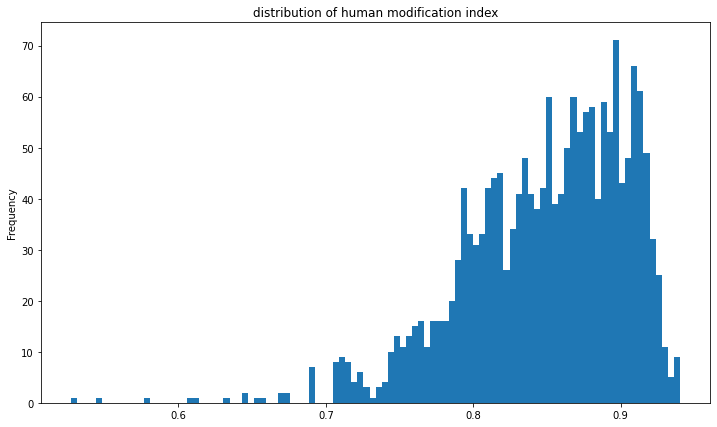

CPU times: user 8.5 s, sys: 418 ms, total: 8.92 s
Wall time: 8min 19s


In [18]:
%%time
ghm = ee.ImageCollection("CSP/HM/GlobalHumanModification").first().select('gHM').clip(india_bounds)

geocoded_loc = geocoded_loc.apply(lambda x: get_reduced_stats(x,
                                                              raster =ghm,
                                                              band='gHM',
                                                              scale = 1000,
                                                              buffer=3000),
                                  axis=1)

geocoded_loc['gHM'].plot.hist(bins=100,figsize=(12,7),title='distribution of human modification index')
plt.show()

**Buildup grid dataset**

    The GHSL relies on the design and implementation of new spatial data mining technologies allowing to automatically process and extract analytics and knowledge from large amount of heterogeneous data including: global, fine-scale satellite image data streams, census data, and crowd sources or volunteered geographic information sources.

    These data contain a multitemporal information layer on built-up presence as derived from Landsat image collections (GLS1975, GLS1990, GLS2000, and ad-hoc Landsat 8 collection 2013/2014). 
    
    Values of build are built ups in each time epoch: 0:'Water Sf',1:'No Builtup',2:'2000-2014',3:'1990-2000',4:'1975-1990',5:'Bf_1975'

In [19]:
%%time
# %%time
built_band_values={'0':'Water Sf',
                   '1':'No Builtup',
                   '2':'2000-2014',
                   '3':'1990-2000',
                   '4':'1975-1990',
                   '5':'Bf_1975'}


bu_grid_data = ee.Image("JRC/GHSL/P2016/BUILT_LDSMT_GLOBE_V1").clip(india_bounds).select('built')



#convert raster to vector
# bu_grid_data.select('built').reduceToVectors(geometry = india_bounds,scale=1000).getInfo()


#get build val
geocoded_loc = geocoded_loc.apply(lambda x: get_reduced_stats(x,
                                                              raster =bu_grid_data,
                                                              band='built',
                                                              scale = 100,
                                                              reducer = ee.Reducer.frequencyHistogram()),
                                  axis=1)

geocoded_loc.head()

CPU times: user 8.03 s, sys: 282 ms, total: 8.32 s
Wall time: 7min 41s


,Address,latitude,longitude,gHM,built
0,"jp nagar phase 1, bangalore, karnataka",12.909960,77.585660,0.896841,"{'2': 263.4980392156863, '3': 252.678431372549..."
1,"dasarahalli on tumkur road, bangalore, karnataka",13.058416,77.468358,0.790173,"{'1': 4, '2': 2392.168627450978, '3': 304.2666..."
2,"kannur on thanisandra main road, bangalore, ka...",13.097668,77.635770,0.799278,"{'1': 14.372549019607842, '2': 1834.8196078431..."
3,"doddanekundi, bangalore, karnataka",12.978390,77.707320,0.865332,"{'1': 7.1607843137254905, '2': 574.65882352941..."
4,"kengeri, bangalore, karnataka",12.908680,77.487180,0.776494,"{'2': 2130.623529411764, '3': 509.458823529411..."


In [20]:
rows = []
for i,row in geocoded_loc.iterrows():
    val_d = row['built']

#     val_d = ast.literal_eval(row['built'])
    rows.append(val_d)
    
    
bu_grid_data = pd.DataFrame(rows)

rename_dict = dict(zip(bu_grid_data.columns.sort_values().values,['Water Sf', 'No Builtup', '2000-2014', '1990-2000', '1975-1990', 'Bf_1975']))
bu_grid_data.rename(columns = rename_dict,inplace=True)
bu_grid_data.replace(np.nan,0,inplace=True)
bu_grid_data.head()

,No Builtup,2000-2014,1990-2000,1975-1990,Bf_1975,Water Sf
0,263.498039,252.678431,295.478431,848.756863,1286.341176,0.000000
1,2392.168627,304.266667,117.835294,112.345098,19.654902,4.000000
2,1834.819608,708.282353,179.745098,131.788235,82.192157,14.372549
3,574.658824,981.427451,416.011765,380.254902,588.901961,7.160784
4,2130.623529,509.458824,154.721569,96.007843,56.000000,0.000000


In [21]:
#merge with features
geocoded_loc = geocoded_loc.merge(bu_grid_data,left_index=True,right_index=True,how='left')
bu = geocoded_loc.pop('built')

**Population Dataset**

    The GHSL relies on the design and implementation of new spatial data mining technologies allowing to automatically process and extract analytics and knowledge from large amount of heterogeneous data including: global, fine-scale satellite image data streams, census data, and crowd sources or volunteered geographic information sources.

    This dataset depicts the distribution and density of population, expressed as the number of people per cell, for reference epochs: 1975, 1990, 2000, 2015.


In [22]:
%%time
population_data = ee.ImageCollection("JRC/GHSL/P2016/POP_GPW_GLOBE_V1")
pop_list = population_data.toList(population_data.size())


#pop in 1975
pop_1975 =ee.Image(pop_list.get(0)).clip(india_bounds).select('population_count')


geocoded_loc = geocoded_loc.apply(lambda x: get_reduced_stats(x,
                                                              raster =pop_1975,
                                                              band='population_count',
                                                              band_name='population_1975',
                                                              scale = 250,
                                                              reducer = ee.Reducer.sum()),
                                  axis=1)




CPU times: user 7.95 s, sys: 261 ms, total: 8.21 s
Wall time: 7min 36s


In [23]:
%%time
pop_2000 =ee.Image(pop_list.get(2)).clip(india_bounds).select('population_count')


geocoded_loc = geocoded_loc.apply(lambda x: get_reduced_stats(x,
                                                              raster =pop_2000,
                                                              band='population_count',
                                                              band_name='population_2000',
                                                              scale = 250,
                                                              reducer = ee.Reducer.sum()),
                                  axis=1)

CPU times: user 8.13 s, sys: 282 ms, total: 8.41 s
Wall time: 7min 22s


In [24]:
%%time
#pop in 2015
pop_2015 =ee.Image(pop_list.get(3)).clip(india_bounds).select('population_count')


geocoded_loc = geocoded_loc.apply(lambda x: get_reduced_stats(x,
                                                              raster =pop_2015,
                                                              band='population_count',
                                                              band_name='population_2015',
                                                              scale = 250,
                                                              reducer = ee.Reducer.sum()),
                                  axis=1)



CPU times: user 8.38 s, sys: 262 ms, total: 8.64 s
Wall time: 8min 51s


# Global Human Settlement Layers

    The Dataset schema is a people-based definition of cities and settlements: it operates using as main input a 1 km² grid cell accounting for population at a given point in time. The DEGURBA discriminates the population grid cells in three main classes: 'urban centers' (cities), 'urban clusters' (towns and suburbs), and 'rural grid cells'. (base). These class abstractions translate to 'high density clusters (HDC)', 'low density clusters (LDC)', and 'rural grid cells (RUR)', respectively, in the GHS-SMOD implementation.

In [27]:
smod_code = {0:'Inhabited areas',1:'RUR',2:'LDC',3:'HDC'}

**1975**

In [28]:
%%time
dens_data = ee.ImageCollection("JRC/GHSL/P2016/SMOD_POP_GLOBE_V1")
dens_list = dens_data.toList(dens_data.size())


#density in 1975
dens_1 =ee.Image(dens_list.get(0)).clip(india_bounds).select('smod_code')


geocoded_loc = geocoded_loc.apply(lambda x: get_reduced_stats(x,
                                                              raster =dens_1,
                                                              band='smod_code',
                                                              band_name='smod_code_1975',
                                                              scale = 1000,
                                                              reducer = ee.Reducer.frequencyHistogram()),
                                  axis=1)




CPU times: user 8.08 s, sys: 287 ms, total: 8.36 s
Wall time: 7min 46s


In [44]:
ds1975 = pd.DataFrame(geocoded_loc.smod_code_1975.tolist())

#rename
rname = {str(key):val + '_1975' for key,val in smod_code.items()}
ds1975.rename(columns = rname,
              inplace=True)

ds1975.fillna(value=0,inplace=True)
ds1975.head()

geocoded_loc = geocoded_loc.merge(ds1975,
                                  left_index=True,
                                  right_index=True,
                                  how='left')

den1 = geocoded_loc.pop('smod_code_1975')

geocoded_loc.head()

,Address,latitude,longitude,gHM,No Builtup,2000-2014,1990-2000,1975-1990,Bf_1975,Water Sf,population_1975,population_2000,population_2015,RUR_1975,LDC_1975,HDC_1975,Inhabited areas_1975
0,"jp nagar phase 1, bangalore, karnataka",12.909960,77.585660,0.896841,263.498039,252.678431,295.478431,848.756863,1286.341176,0.000000,20442.752242,39925.003554,48264.900040,7.556863,7.705882,12.72549,0.000000
1,"dasarahalli on tumkur road, bangalore, karnataka",13.058416,77.468358,0.790173,2392.168627,304.266667,117.835294,112.345098,19.654902,4.000000,5513.172176,86314.817122,248456.313269,4.286275,3.874510,0.00000,19.811765
2,"kannur on thanisandra main road, bangalore, ka...",13.097668,77.635770,0.799278,1834.819608,708.282353,179.745098,131.788235,82.192157,14.372549,5925.200153,71140.111106,301992.330902,18.286275,3.670588,0.00000,6.027451
3,"doddanekundi, bangalore, karnataka",12.978390,77.707320,0.865332,574.658824,981.427451,416.011765,380.254902,588.901961,7.160784,4458.845208,13985.929011,21277.616579,27.996078,0.000000,0.00000,0.000000
4,"kengeri, bangalore, karnataka",12.908680,77.487180,0.776494,2130.623529,509.458824,154.721569,96.007843,56.000000,0.000000,1014.963773,4971.193143,14422.423274,13.392157,0.000000,0.00000,14.564706


**1990**

In [45]:
%%time
dens_1 =ee.Image(dens_list.get(1)).clip(india_bounds).select('smod_code')


geocoded_loc = geocoded_loc.apply(lambda x: get_reduced_stats(x,
                                                              raster =dens_1,
                                                              band='smod_code',
                                                              band_name='smod_code_1990',
                                                              scale = 1000,
                                                              reducer = ee.Reducer.frequencyHistogram()),
                                  axis=1)


ds_y = pd.DataFrame(geocoded_loc.smod_code_1990.tolist())

#rename
rname = {str(key):val + '_1990' for key,val in smod_code.items()}

ds_y.rename(columns = rname,
              inplace=True)

ds_y.fillna(value=0,inplace=True)



geocoded_loc = geocoded_loc.merge(ds_y,
                                  left_index=True,
                                  right_index=True,
                                  how='left')

den2 = geocoded_loc.pop('smod_code_1990')

CPU times: user 7.84 s, sys: 249 ms, total: 8.09 s
Wall time: 8min 37s


**2000**

In [47]:
dens_1 =ee.Image(dens_list.get(2)).clip(india_bounds).select('smod_code')


geocoded_loc = geocoded_loc.apply(lambda x: get_reduced_stats(x,
                                                              raster =dens_1,
                                                              band='smod_code',
                                                              band_name='smod_code_2000',
                                                              scale = 1000,
                                                              reducer = ee.Reducer.frequencyHistogram()),
                                  axis=1)


ds_y = pd.DataFrame(geocoded_loc.smod_code_2000.tolist())

#rename
rname = {str(key):val + '_2000' for key,val in smod_code.items()}

ds_y.fillna(value=0,inplace=True)


ds_y.rename(columns = rname,
              inplace=True)

ds_y.head()

,LDC_2000,HDC_2000,Inhabited areas_2000,RUR_2000
0,0.172549,27.815686,0.000000,0.000000
1,1.627451,14.070588,0.349020,11.925490
2,0.000000,21.996078,0.000000,5.988235
3,13.301961,10.388235,0.000000,4.305882
4,6.470588,0.000000,0.878431,20.607843


In [48]:
geocoded_loc = geocoded_loc.merge(ds_y,
                                  left_index=True,
                                  right_index=True,
                                  how='left')

den3 = geocoded_loc.pop('smod_code_2000')

**2014**

In [50]:
dens_1 =ee.Image(dens_list.get(3)).clip(india_bounds).select('smod_code')


geocoded_loc = geocoded_loc.apply(lambda x: get_reduced_stats(x,
                                                              raster =dens_1,
                                                              band='smod_code',
                                                              band_name='smod_code_2014',
                                                              scale = 1000,
                                                              reducer = ee.Reducer.frequencyHistogram()),
                                  axis=1)


ds_y = pd.DataFrame(geocoded_loc.smod_code_2014.tolist())

#rename
rname = {str(key):val + '_2014' for key,val in smod_code.items()}
ds_y.fillna(value=0,inplace=True)

ds_y.rename(columns = rname,
              inplace=True)

ds_y.head()

,HDC_2014,RUR_2014,LDC_2014,Inhabited areas_2014
0,27.988235,0.000000,0.000000,0.0
1,25.184314,1.482353,1.305882,0.0
2,22.282353,2.596078,3.105882,0.0
3,27.192157,0.101961,0.701961,0.0
4,6.431373,13.494118,8.031373,0.0


In [52]:
geocoded_loc = geocoded_loc.merge(ds_y,
                                  left_index=True,
                                  right_index=True,
                                  how='left')

den4 = geocoded_loc.pop('smod_code_2014')

In [53]:
geocoded_loc.head()

,Address,latitude,longitude,gHM,No Builtup,2000-2014,1990-2000,1975-1990,Bf_1975,Water Sf,...,HDC_1990,Inhabited areas_1990,LDC_2000,HDC_2000,Inhabited areas_2000,RUR_2000,HDC_2014,RUR_2014,LDC_2014,Inhabited areas_2014
0,"jp nagar phase 1, bangalore, karnataka",12.909960,77.585660,0.896841,263.498039,252.678431,295.478431,848.756863,1286.341176,0.000000,...,20.901961,0.000000,0.172549,27.815686,0.000000,0.000000,27.988235,0.000000,0.000000,0.0
1,"dasarahalli on tumkur road, bangalore, karnataka",13.058416,77.468358,0.790173,2392.168627,304.266667,117.835294,112.345098,19.654902,4.000000,...,7.337255,7.298039,1.627451,14.070588,0.349020,11.925490,25.184314,1.482353,1.305882,0.0
2,"kannur on thanisandra main road, bangalore, ka...",13.097668,77.635770,0.799278,1834.819608,708.282353,179.745098,131.788235,82.192157,14.372549,...,6.000000,0.000000,0.000000,21.996078,0.000000,5.988235,22.282353,2.596078,3.105882,0.0
3,"doddanekundi, bangalore, karnataka",12.978390,77.707320,0.865332,574.658824,981.427451,416.011765,380.254902,588.901961,7.160784,...,0.000000,0.000000,13.301961,10.388235,0.000000,4.305882,27.192157,0.101961,0.701961,0.0
4,"kengeri, bangalore, karnataka",12.908680,77.487180,0.776494,2130.623529,509.458824,154.721569,96.007843,56.000000,0.000000,...,0.000000,9.901961,6.470588,0.000000,0.878431,20.607843,6.431373,13.494118,8.031373,0.0


In [54]:
geocoded_loc.to_csv('additional_features.csv',index=False)

In [55]:
!ls

__notebook_source__.ipynb  additional_features.csv  geocoded.csv


**Join with main df and save**

In [56]:
df_fin = df.merge(geocoded_loc,
              left_on='Address',
              right_on ='Address',
              how='inner')

df_fin.shape

(32963, 70)

In [57]:
df_fin.columns

Index(['Price', 'Area', 'Location', 'No. of Bedrooms', 'Resale',
       'MaintenanceStaff', 'Gymnasium', 'SwimmingPool', 'LandscapedGardens',
       'JoggingTrack', 'RainWaterHarvesting', 'IndoorGames', 'ShoppingMall',
       'Intercom', 'SportsFacility', 'ATM', 'ClubHouse', 'School',
       '24X7Security', 'PowerBackup', 'CarParking', 'StaffQuarter',
       'Cafeteria', 'MultipurposeRoom', 'Hospital', 'WashingMachine',
       'Gasconnection', 'AC', 'Wifi', 'Children'splayarea', 'LiftAvailable',
       'BED', 'VaastuCompliant', 'Microwave', 'GolfCourse', 'TV',
       'DiningTable', 'Sofa', 'Wardrobe', 'Refrigerator', 'City', 'Address',
       'latitude', 'longitude', 'gHM', 'No Builtup', '2000-2014', '1990-2000',
       '1975-1990', 'Bf_1975', 'Water Sf', 'population_1975',
       'population_2000', 'population_2015', 'RUR_1975', 'LDC_1975',
       'HDC_1975', 'Inhabited areas_1975', 'RUR_1990', 'LDC_1990', 'HDC_1990',
       'Inhabited areas_1990', 'LDC_2000', 'HDC_2000', 'Inhabited a

In [58]:
df_fin.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,HDC_1990,Inhabited areas_1990,LDC_2000,HDC_2000,Inhabited areas_2000,RUR_2000,HDC_2014,RUR_2014,LDC_2014,Inhabited areas_2014
0,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0
1,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0
2,30000000,3340,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0
3,29600000,3300,JP Nagar Phase 1,4.0,0,1.0,1.0,1.0,1.0,1.0,...,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0
4,2899000,3145,JP Nagar Phase 1,4.0,1,NaN,NaN,NaN,NaN,NaN,...,20.901961,0.0,0.172549,27.815686,0.0,0.0,27.988235,0.0,0.0,0.0


In [59]:
df_fin.to_csv('final_df.csv',index=False)

In [65]:
!ls

__notebook_source__.ipynb  additional_features.csv  final_df.csv  geocoded.csv
